In [1]:
# importing required libraries 
import re
import pandas as pd

# for pytorch imports
import torch

# for functional dependencies like activation function 
import torch.nn.functional as F

# nn is basic module in Torch which provide different neural network architecture
import torch.nn as nn

# for optimizer
import torch.optim as optim

# for padding .. since the LSTM takes input as sequence so it is said that 
#if we have fixed input string computation will be faster and it will improve performance 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader

In [2]:
# ハイパーパラメータ
MAX_WORDS_LEN = 512
BATCH_SIZE = 128
EMBEDDING_SIZE = 256
NUM_LAYERS = 1
HIDDEN_SIZE = 128
N_EPOCH = 10

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# 学習データの準備
from torchtext.datasets import IMDB

train_iter, test_iter = IMDB()

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.transforms import Sequential, VocabTransform, Truncate, ToTensor

tokenizer = get_tokenizer("basic_english")
tokenize = lambda x: tokenizer(re.sub(r'["\'`;:\(\),-]', '', x))
train_text = train_iter.map(lambda x: tokenize(x[1]))
vocab = build_vocab_from_iterator(train_text, specials=('<unk>', '<pad>'), min_freq=200)
vocab.set_default_index(vocab['<unk>'])
# print(vocab.get_stoi())
print(f'vocabulary num: {len(vocab)}')

text_transform = Sequential(
    VocabTransform(vocab),
    Truncate(max_seq_len=MAX_WORDS_LEN),
    ToTensor(padding_value=vocab['<pad>'])
);

def collate_batch(batch):
    texts = text_transform([tokenize(text) for (label, text) in batch])
    labels = torch.FloatTensor([label - 1 for (label, text) in batch])
    raw_text = [text for (label, text) in batch]
    return texts, labels, raw_text

train_dataloader = DataLoader(train_iter, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dataloader = DataLoader(test_iter, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_batch)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/utils/common.py:145: UserWarning: Lambda function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


vocabulary num: 2445


In [5]:
def debug_data():
    label, text = next(iter(train_iter))
    print(text, label)
    tokenized_text = tokenize(text)
    print(tokenized_text)
    transformed_text = text_transform(tokenized_text)
    print(transformed_text)

debug_data()

This movie isn't very good. It's boring, and not much blood for a horror film. The plot just trods along with not much happening. And I think the female vampire was so stupid. She had many chances to kill the vampire hunters since it shows her having lighting like reflexes. But, whenever she has one of them pinned, she just takes her time and something always happens where she doesn't bite them. No wonder this went straight to cable.<br /><br />FINAL VERDICT: Not anywhere near as good as the first Vampire movie. You're a SUCKER if you waste your time on this. 1
['this', 'movie', 'isnt', 'very', 'good', '.', 'its', 'boring', 'and', 'not', 'much', 'blood', 'for', 'a', 'horror', 'film', '.', 'the', 'plot', 'just', 'trods', 'along', 'with', 'not', 'much', 'happening', '.', 'and', 'i', 'think', 'the', 'female', 'vampire', 'was', 'so', 'stupid', '.', 'she', 'had', 'many', 'chances', 'to', 'kill', 'the', 'vampire', 'hunters', 'since', 'it', 'shows', 'her', 'having', 'lighting', 'like', 'refle

In [6]:
class RNN(nn.Module):
     def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(RNN, self).__init__()
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, 1)
        
     def forward(self, inputs):
        encoded = self.encoder(inputs)
        output, hidden = self.rnn(encoded)
        pooled = F.max_pool1d(output.permute(0,2,1), output.shape[1]).squeeze(2)
        output = self.decoder(pooled).squeeze()
        return output

model = RNN(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_SIZE,
    hidden_dim=HIDDEN_SIZE,
    num_layers=NUM_LAYERS
)
model = model.to(device)
model

RNN(
  (encoder): Embedding(2445, 256)
  (rnn): GRU(256, 128, batch_first=True)
  (decoder): Linear(in_features=128, out_features=1, bias=True)
)

In [7]:
# モデルの訓練と評価
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

train_accs = [0] * N_EPOCH
train_losses = [0] * N_EPOCH
test_accs = [0] * N_EPOCH
test_losses = [0] * N_EPOCH
for epoch in range(N_EPOCH):
    model.train()
    train_total = 0
    train_acc = 0
    train_loss = 0
    for batch in train_dataloader:
        texts, labels, _ = batch
        texts, labels = texts.to(device), labels.to(device)

        # パラメータの勾配をリセット
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        acc = binary_accuracy(predictions, labels)
        train_total += 1
        train_acc += acc.item()
        train_loss += loss.item()

    model.eval()
    test_total = 0
    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            texts, labels, _ = batch
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            test_total += 1
            test_acc += acc.item()
            test_loss += loss.item()

    # LossとAccuracyを表示
    train_accs[epoch] = train_acc / train_total
    train_losses[epoch] = train_loss / train_total
    test_accs[epoch] = test_acc / test_total
    test_losses[epoch] = test_loss / test_total
    print(f'Epoch: {epoch+1}, Train Acc: {train_accs[epoch]:.3f}, Train Loss: {train_losses[epoch]:.3f}, Test Acc: {test_accs[epoch]:.3f}, Test Loss: {test_losses[epoch]:.3f}')

Epoch: 1, Train Acc: 0.716, Train Loss: 0.563, Test Acc: 0.648, Test Loss: 0.626
Epoch: 2, Train Acc: 0.765, Train Loss: 0.520, Test Acc: 0.737, Test Loss: 0.543
Epoch: 3, Train Acc: 0.832, Train Loss: 0.427, Test Acc: 0.787, Test Loss: 0.462
Epoch: 4, Train Acc: 0.858, Train Loss: 0.360, Test Acc: 0.824, Test Loss: 0.400
Epoch: 5, Train Acc: 0.886, Train Loss: 0.291, Test Acc: 0.848, Test Loss: 0.354
Epoch: 6, Train Acc: 0.903, Train Loss: 0.249, Test Acc: 0.845, Test Loss: 0.365
Epoch: 7, Train Acc: 0.913, Train Loss: 0.225, Test Acc: 0.863, Test Loss: 0.330
Epoch: 8, Train Acc: 0.926, Train Loss: 0.195, Test Acc: 0.869, Test Loss: 0.325
Epoch: 9, Train Acc: 0.940, Train Loss: 0.168, Test Acc: 0.870, Test Loss: 0.322
Epoch: 10, Train Acc: 0.948, Train Loss: 0.145, Test Acc: 0.872, Test Loss: 0.323


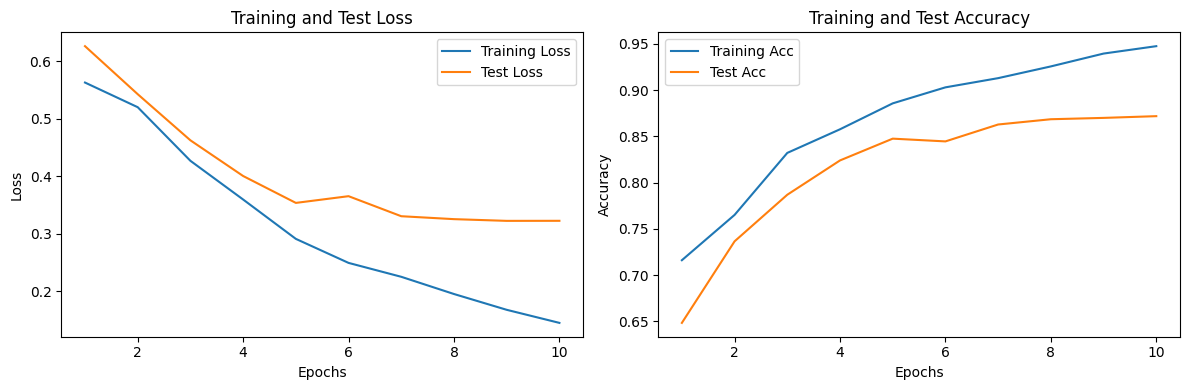

In [8]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, test_losses, train_accs, test_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Training Acc')
    plt.plot(epochs, test_accs, label='Test Acc')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(train_losses, test_losses, train_accs, test_accs)

In [9]:
model.eval()
test_data = next(iter(test_dataloader))
texts, labels, raw_text = test_data
texts = texts.to(device)
predictions = model(texts)
results = [(raw_text[i], labels[i].item(), f"{torch.sigmoid(pred):.3f}") for i, pred in enumerate(predictions)]
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', None)
df = pd.DataFrame(results, columns=['text', 'label', 'pred'])
df

,text,label,pred
0,"This movie is really stupid and very boring most of the time. There are almost no ""ghoulies"" in it at all. There is nothing good about this movie on any level. Just more bad actors pathetically attempting to make a movie so they can get enough money to eat. Avoid at all costs.",0.0,0.004
1,"Bloody Birthday is a totally rubbish slasher movie from beginning to end. <br /><br />I found the acting to be pretty good considering the genre of movie and its obvious low budget. I don't know what was going on with the cinematography but it looked ghastly. Way too over-saturated. Maybe this is a bad transfer to DVD or maybe it always looked like that, I don't know. <br /><br />There really are no redeeming qualities to speak of. There are a few deaths but not really gory. I wouldn't bothe...",0.0,0.019
2,"This flick is TERRIBLE! It sets out to disgust and make you laugh, but it fails horribly. The director obviously has no sense of slap stick gore comedy, and the actors are like nothing I've ever seen - lacking both acting talent and flair of comedy. Even their attempt at the English languish is really sad, and actually the down right peculiar Swedish accent, in which the incoherent dialog is spoken, is probably the most comical and enjoyable thing about this film. Even the gore i awful and u...",0.0,0.005
3,"It would be wrong and reprehensible of me to advise you to watch Killjoy 2, you must have better things to do, washing the car, throwing stones in a stream, but at the same time it's nowhere near as awful as you probably think it is. It's almost a proper film, which a lot more than most straight-to-DVD sludge can manage. Killjoy 2 is helped a great deal by Trent Haaga's manic turn as the eponymous clown, he throws himself into the role with such fevered abandonment that he almost tips the sc...",0.0,0.993
4,"Firstly I loved the book, more so than the more popular Da Vinci Code and although the DVC film was not well received, I liked it and bought the DVD. However, there is no chance that I will ever want to watch Angles and Demons ever again.<br /><br />The film barely resembles the book, in fact only the general premise of the story is there.<br /><br />From the very start of the film I was disappointed, in the book Robert Langdon receives a call and fax from Maximilian Kohler, Director of CERN...",0.0,0.047
5,"yeah..that's what the station disclaimer states after the commercials for this show ""some scenes may be disturbing to some viewers"" .<br /><br />It is beyond disturbing. The validation of this whole display of ego framing and chauvinism is in the fact it is on the COMEDY channel. Yes..a comedy true and true. A JOKE. To see these 'playas' go through their rigid charade really spells out what is wrong with society. Especially the meat market bar scene. Both sides, the male and female, are equa...",0.0,0.188
6,"The Most Fertile Man in Ireland revolves around Eamon Manley who is 24 year old and still happens to be a virgin. He lives with his mother in Belfast. He is also a very shy guy towards women. Everything has changes for Eamon when he is seduced by a woman(as far as I can remember a neighbour). It is not because he looses his virginity but he discovers that he has a super power. Despite having protection, this neighbour becomes pregnant. He is told by the doctor that he has very high sperm cou...",0.0,0.837
7,"I appear to be in the minority, but I thought ""Radio"" was pretty awful. It seemed to contain almost every cliche in these types of ""heartwarming"" movies.<br /><br />The motivation for the characters falling in love with Radio was never really explained. We were just supposed to accept that everyone was fond of Radio except for a couple of bad apples.<br /><br />You could see almost all of th big moments in the story from 100 yards away. When the movie wanted you to go ""Awww"" or pull out your...",0.0,0.004
8,"That is what this movie is. Good God the special effects suck in this movie. It 

In [10]:
!sudo apt-get install -y graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [11]:
from torchviz import make_dot
image = make_dot(predictions, params=dict(model.named_parameters()))
image.format = "png"
image.render("../images/GRU")

'../images/GRU.png'